In [1]:
from math import pi
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.colors as pcl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import time
import GPUtil

from LRvismod3d import *
from basicFun import readparm

In [2]:
# define a specific 3-D snapshot display function
def show3Dnew(md, xyz, xyzi, clim, cbl=None,cs=None):
    
    # slice given index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
    rg = [clim[0],clim[1]-clim[0]]
    
    # plot the model
    fig = plt.figure(figsize = (12,5))
    ax = fig.gca(projection='3d')
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[1][0],xyz[1][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg)
    ax = slice_show(ax, mx, xyz, 1, rg=rg)
    ax = slice_show(ax, my, xyz, 2, rg=rg)
    
    # set the axes
    xtick = np.arange(0,9001,1500)
    ytick = np.arange(0,4501,1500)
    ztick = np.linspace(0,xyz[2][-1],4)
    ax.set_xticks(xtick)
    ax.set_xticklabels([f'{i/1e3}' for i in xtick],fontsize=12)
    ax.set_yticks(ytick)
    ax.set_yticklabels([f'{i/1e3}' for i in ytick],fontsize=12)
    ax.set_zticks(ztick)
    ax.set_zticklabels([f'{i/1e3}' for i in ztick],fontsize=12)
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.view_init(elev=30,azim=-70)
    
    # set the labels
    ax.text(4000, -2500, 2800, 'x (km)', (1,-0.15,0), fontsize=15)
    ax.text(-2600, 500, 2800, 'y (km)', (-0.3,1,0), fontsize=15)
    ax.text(-2000, 5000, 1800, 'z (km)', (0,0,1), fontsize=15)
    
    
    # colorbar
    if cs == None:
        cs = 1
    cb = fig.colorbar(cm.ScalarMappable(norm=cN, cmap='bwr'))
    ctick = np.linspace(clim[0],clim[1],5)
    cb.set_ticks(ctick)
    cb.set_ticklabels([f'{int(i/cs):.1f}' for i in ctick])
    cb.ax.tick_params(labelsize=15)
    if cbl is not None:
        cb.set_label(cbl,fontsize=20)

    plt.show()

    return fig, ax

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(1,1)):
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.bwr(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1)
    
    return ax

In [3]:
# define a specific 3-D data volume display function
def show3Ddata(md, xyz, xyzi, clim):
    
    # slice given index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
    rg = [clim[0],clim[1]-clim[0]]
    
    # plot the model
    fig = plt.figure(figsize = (12,10))
    ax = fig.gca(projection='3d')
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[1][0],xyz[1][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg)
    ax = slice_show(ax, mx, xyz, 1, rg=rg)
    ax = slice_show(ax, my, xyz, 2, rg=rg)
    
    # set the axes
    xtick = np.arange(xyz[0][0],xyz[0][-1]+1,1500)
    ytick = np.arange(xyz[1][0],xyz[1][-1]+1,1000)
    ztick = np.linspace(xyz[2][0],xyz[2][-1],5)
    ax.set_xticks(xtick)
    ax.set_xticklabels([f'{i/1e3}' for i in xtick],fontsize=12)
    ax.set_yticks(ytick)
    ax.set_yticklabels([f'{i/1e3}' for i in ytick],fontsize=12)
    ax.set_zticks(ztick)
    ax.set_zticklabels([f'{i}' for i in ztick],fontsize=12)
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.view_init(elev=30,azim=-60)
    
    # set the labels
    ax.text(4000, -600, 2, 'x (km)', (1,-0.05,0), fontsize=15)
    ax.text(-1200, 1400, 2, 'y (km)', (-0.3,1,0), fontsize=15)
    ax.text(-1200, 3500, 1, 'Time (s)', (0,0,1), fontsize=15)

    plt.show()

    return fig, ax

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(1,1)):
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.bwr(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1, shade='interp')
    
    return ax

In [4]:
# define pathes
inpath = './resources/truncOT_model'
outpath = './outputs/AGUpaper'

In [5]:
# readin basic parm
basic_parm = readparm(inpath)

Temporal step length (dt/s):

0.001

Recording time steps (nt/1):

2001

Reference frequency (f0/Hz):

20

Low rank decomposition number along x (ln):

4

Low rank decomposition number along k (lm):

4


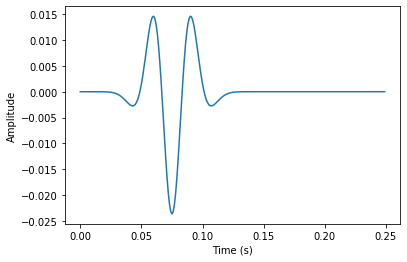

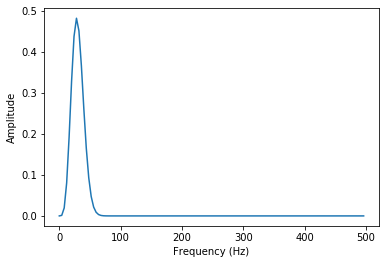

In [6]:
# create source class
nt = basic_parm[1]
dt = basic_parm[0]
fs = 20 # dominant frequency of Ricker wavelet
t0 = -1.5/fs
sl = round(5/fs/dt)
s = source(fs, dt, t0, sl, order=2, tol=1e-2)
s.ws = np.linspace(8.0,62.0,10)*2*pi # define the source valid frequency samples

In [7]:
print(s.ws) # initial frequency samples

[ 50.26548246  87.9645943  125.66370614 163.36281799 201.06192983
 238.76104167 276.46015352 314.15926536 351.8583772  389.55748905]


In [8]:
v = model('velocity.h', inpath, f0=basic_parm[2])
Q = model('Qaulity_factor.h', inpath)

In [9]:
r'''V = v.md
Q = 3.516*(V/1000)**2.2
Q = np.array(np.reshape(Q,(601*301*187),'F'),dtype = '>f4')
Q.tofile('./resources/truncOT_model/Q.dat')'''

"V = v.md\nQ = 3.516*(V/1000)**2.2\nQ = np.array(np.reshape(Q,(601*301*187),'F'),dtype = '>f4')\nQ.tofile('./resources/truncOT_model/Q.dat')"

In [10]:
fig, _ = show3Dnew(v.md,[v.x,v.y,v.z],[0,0,0],clim=[2000,6000],cbl='$v_0$ (km/s)',cs=1e3)

In [11]:
fig.savefig('./outputs/AGUpaper/hete_v.png',dpi=600)

In [12]:
fig, _ = show3Dnew(Q.md,[v.x,v.y,v.z],[0,0,0],clim=[21,181],cbl='$Q$')

In [13]:
fig.savefig('./outputs/AGUpaper/hete_Q.png',dpi=600)

In [14]:
# create source and reciever indices
def createids():
    indx = [300]
    indy = [150]
    indz = [10]
    tmp = OrderedDict(x=indx,
                       y=indy,
                       z=indz)
    ids = np.array([v for v in product(*tmp.values())],dtype=np.int16)
    return ids

def createidr():
    indx = range(50,551,2)
    indy = range(50,251,4)
    indz = [5]
    tmp = OrderedDict(x=indx,
                       y=indy,
                       z=indz)
    idr = np.array([v for v in product(*tmp.values())],dtype=np.int16)
    return idr  

ids = createids()
idr = createidr()

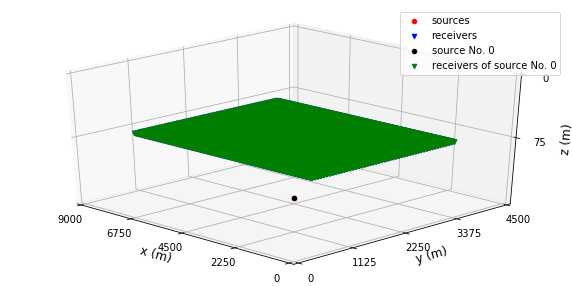

In [15]:
# test acqgeo class
geometry = acqgeo(ids, idr)
# display the acquisation geometry
_ = geometry.geometry_show(v.x,v.y,v.z,ea=(30,-45))

In [16]:
# test modeling class
vmh = 'velocity.h'
Qmh = 'Qaulity_factor.h'

In [17]:
# set the clim for snapshots
# when test for computational time, let tsample=[], since the snapshot display and saving cost some time
# when display the snapshots, let tsample = [400,800]
tsample = [700,1400]
clim = None#[-0.001,0.0005]
nxline = 251
niline = 51

## (1) Natural-attenuation absorbing boundary condition $\varepsilon=0.05$

In [18]:
LRM = LRmodeling(basic_parm,s,geometry,vmh,Qmh,typ_tsc=2,abc={'naABCs':0.05},inpath=inpath,outpath=outpath)

Model expanding for naABC...
Total No. of unique roundup (v,g) pairs: 1708.


[========================================================================] 100%


Plane boundary expanding...
Edge boundary expanding...
Corner boundary expanding...
Absorbing layer No: 44
Runtime for preparing ABCs: 126.68069839477539 s
Low-rank decomposition...
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.3460000e+03 1.3800000e-02]
 [6.0000000e+03 1.7573736e-03]
 [2.8582908e+03 1.9728827e-01]
 [4.4160000e+03 3.3999998e-03]]
Ws for W2
RRQR for Ws
Principal K components:[0.36183396 0.24119274 0.12931326 0.32261341]
Ws for W1
RRQR for Ws
Principal Px combinations:[[3.0380000e+03 7.7999998e-03]
 [5.3532458e+02 4.9900001e-01]
 [3.5116418e+03 1.3585773e-01]
 [6.0000000e+03 1.7573736e-03]]
Ws for W2
RRQR for Ws
Principal K components:[0.36183396 0.17390857 0.05626247 0.28515306]
Runtime for low-rank decomposition: 39.526893854141235 s
Model parameter calculation...
Modeling preparation done!


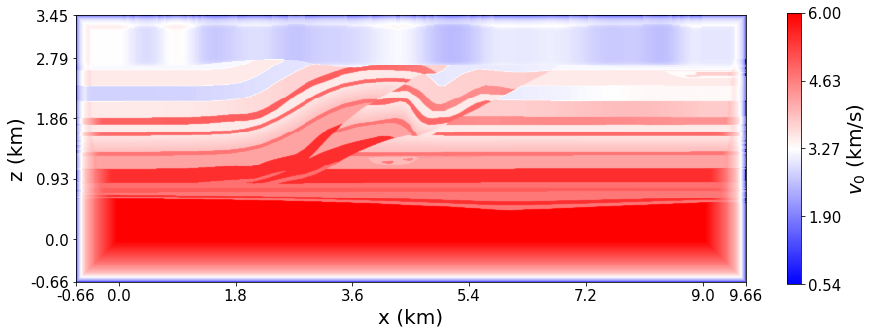

In [19]:
ztk = np.linspace(0,v.z[-1],4)
ztk = np.insert(ztk,0,-660)
ztk = np.append(ztk,v.z[-1]+660)
xtk = np.linspace(0,v.x[-1],6)
xtk = np.insert(xtk,0,-660)
xtk = np.append(xtk,v.x[-1]+660)

# display the sliced v0 and gamma
ind = np.arange(LRM.vgme.ne[1])
indy = ind[LRM.vgme.ye==2100][0]
vme = LRM.vgme.vme[:,indy,:].transpose()
gme = LRM.vgme.gme[:,indy,:].transpose()
Qme = 1/np.tan(gme*pi)
Vmin = np.amin(vme)
Vmax = np.amax(vme)
Qmin = np.amin(Qme)
Qmax = np.amax(Qme)

fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.imshow(vme,cmap='bwr',extent=[LRM.vgme.xe[0],LRM.vgme.xe[-1],LRM.vgme.ze[0],LRM.vgme.ze[-1]])
ax.set_xticks(xtk)
ax.set_yticks(ztk)
ax.set_xticklabels([f'{i/1e3}' for i in xtk],fontsize=15)
ax.set_yticklabels([f'{i/1e3}' for i in ztk],fontsize=15)
ax.set_xlabel('x (km)',fontsize=20)
ax.set_ylabel('z (km)',fontsize=20)
cN = pcl.Normalize(vmin=Vmin, vmax=Vmax)
cb = fig.colorbar(cm.ScalarMappable(norm=cN, cmap='bwr'))
ctick = np.linspace(Vmin,Vmax,5)
cb.set_ticks(ctick)
cb.set_ticklabels([f'{i/1e3:.2f}' for i in ctick])
cb.ax.tick_params(labelsize=15)
cb.set_label('$v_0$ (km/s)',fontsize=20)

In [20]:
fig.savefig('./outputs/AGUpaper/hete_vslice.png',dpi=600)

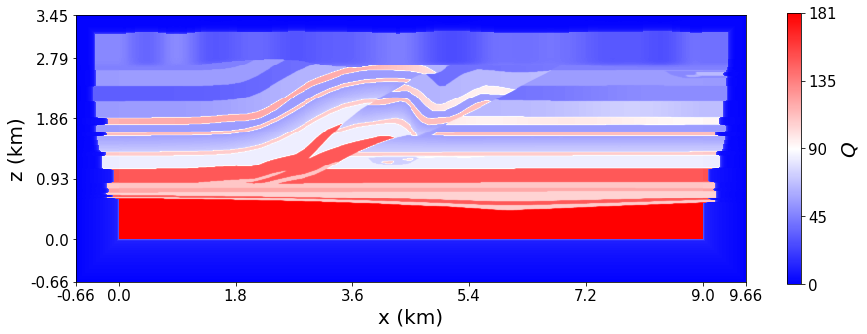

In [21]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.imshow(Qme,cmap='bwr',extent=[LRM.vgme.xe[0],LRM.vgme.xe[-1],LRM.vgme.ze[0],LRM.vgme.ze[-1]])
ax.set_xticks(xtk)
ax.set_yticks(ztk)
ax.set_xticklabels([f'{i/1e3}' for i in xtk],fontsize=15)
ax.set_yticklabels([f'{i/1e3}' for i in ztk],fontsize=15)
ax.set_xlabel('x (km)',fontsize=20)
ax.set_ylabel('z (km)',fontsize=20)
cN = pcl.Normalize(vmin=Qmin, vmax=Qmax)
cb = fig.colorbar(cm.ScalarMappable(norm=cN, cmap='bwr'))
ctick = np.linspace(Qmin,Qmax,5)
cb.set_ticks(ctick)
cb.set_ticklabels([f'{int(i)}' for i in ctick])
cb.ax.tick_params(labelsize=15)
cb.set_label('$Q$',fontsize=20)

In [22]:
fig.savefig('./outputs/AGUpaper/hete_Qslice.png',dpi=600)

In [23]:
print('GPU usage after loading model parameters:')
GPUtil.showUtilization()

GPU usage after loading model parameters:
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


Source No. progress:
Time progress:


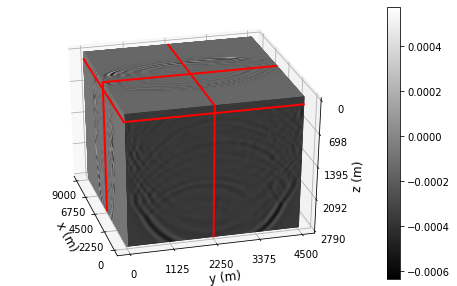

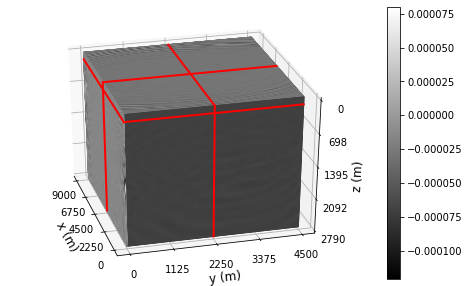

[========================================================================] 100%


601.742116689682


In [24]:
st = time.time()
rec,fig,ax = LRM.LRiteration(tsample=tsample,clim=clim) # if efficiency is tested, set tsample=[]
T = time.time()-st
print(T)

0.0011519975


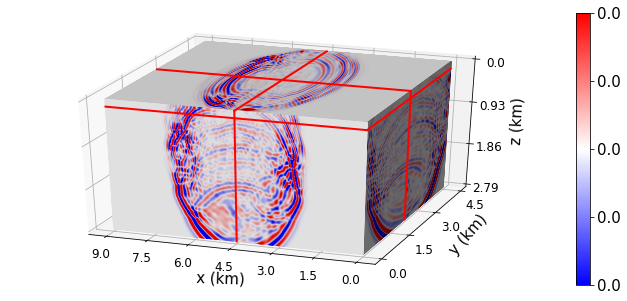

0.00016732463


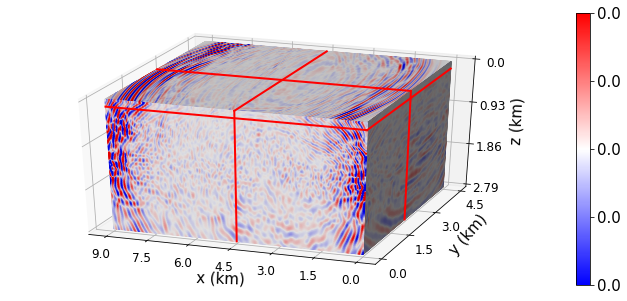

In [25]:
clim1 = np.array([-0.00115,0.00115])*0.1
clim2 = np.array([-0.0001665,0.0001665])*0.1
# readin the sampled snapshots
if tsample is not None:
    fig = []
    for it in tsample:
        sp = np.fromfile(f'{outpath}/snapshot_it={it}.dat',dtype=np.float32)
        sp = np.reshape(sp,v.n)
        print(np.amax(np.abs(sp)))
        if it == tsample[0]:
            clim = clim1
        else:
            clim = clim2
        figt, _ = show3Dnew(sp, [v.x,v.y,v.z], ids[0], clim=clim)
        fig.append(figt)

In [26]:
rec.tofile('./outputs/AGUpaper/hete_rec_naABC.dat')

In [27]:
rec = np.fromfile('./outputs/AGUpaper/hete_rec_naABC.dat',dtype=np.float32)
recna = np.reshape(rec,(nt,nxline,niline))

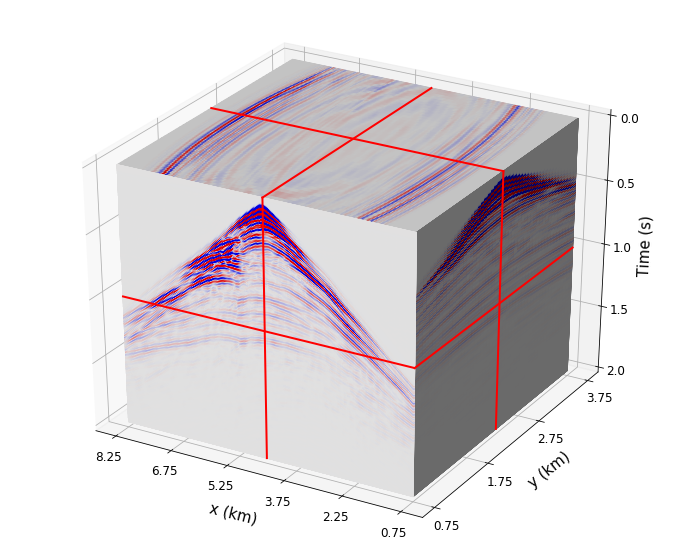

In [28]:
# display the 3-D data volume
rec = np.fromfile('./outputs/AGUpaper/hete_rec_naABC.dat',dtype=np.float32)
recdisp = np.reshape(rec,(nt,nxline*niline)).transpose()
recdisp = np.reshape(recdisp,(nxline,niline,nt))
clim = np.array([-0.001,0.001])*0.1
x = np.arange(50,551,2)*15
y = np.arange(50,251,4)*15
z = np.arange(nt)*dt
fig, _ = show3Ddata(recdisp, [x,y,z], [126,26,nt//2], clim=clim)

In [29]:
fig.savefig('./outputs/AGUpaper/hete_rec3D_naABC.png',dpi=600)

## (2) Hybird absorbing boundary conditions $N=20$

In [30]:
LRM = LRmodeling(basic_parm,s,geometry,vmh,Qmh,typ_tsc=2,abc={'hABCs':20},inpath=inpath,outpath=outpath)

Model expanding for hABC...
Plane No: 1
Plane No: 2
Plane No: 3
Plane No: 4
Plane No: 5
Plane No: 6
Edge No: 1
Edge No: 2
Edge No: 3
Edge No: 4
Edge No: 5
Edge No: 6
Edge No: 7
Edge No: 8
Edge No: 9
Edge No: 10
Edge No: 11
Edge No: 12
Corner No: 1
Corner No: 2
Corner No: 3
Corner No: 4
Corner No: 5
Corner No: 6
Corner No: 7
Corner No: 8
Absorbing layer No: 20
Runtime for preparing ABCs: 11.583987951278687 s
Low-rank decomposition...
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.3645078e+03 1.3624050e-02]
 [6.0000000e+03 1.7573736e-03]
 [4.8903750e+03 2.7557360e-03]
 [3.2095330e+03 6.9592101e-03]]
Ws for W2
RRQR for Ws
Principal K components:[0.36168418 0.24924345 0.32066962 0.11100634]
Ws for W1
RRQR for Ws
Principal Px combinations:[[3.0183518e+03 7.9655703e-03]
 [6.0000000e+03 1.7573736e-03]
 [2.2737754e+03 1.4847095e-02]
 [4.8280669e+03 2.8345787e-03]]
Ws for W2
RRQR for Ws
Principal K components:[0.36168418 0.2006272  0.05891418 0.3034012 ]
Runtime for low-rank decomposition:

In [31]:
print('GPU usage after loading model parameters:')
GPUtil.showUtilization()

GPU usage after loading model parameters:
| ID | GPU | MEM |
------------------
|  0 | 20% |  2% |


Source No. progress:
Time progress:


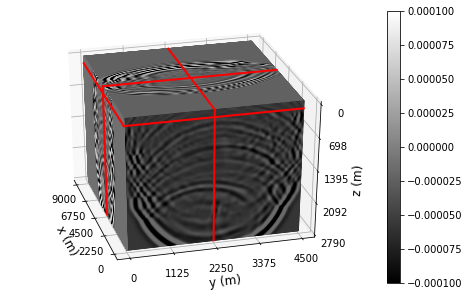

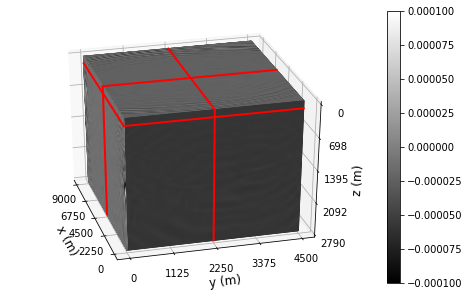

[========================================================================] 100%


1146.6410896778107


In [32]:
st = time.time()
rec,fig,ax = LRM.LRiteration(tsample=tsample,clim=clim) # if efficiency is tested, set tsample=[]
T = time.time()-st
print(T)

In [33]:
rec.tofile('./outputs/AGUpaper/hete_rec_hABC.dat')

In [34]:
rec = np.fromfile('./outputs/AGUpaper/hete_rec_hABC.dat',dtype=np.float32)
rech = np.reshape(rec,(nt,251,51))

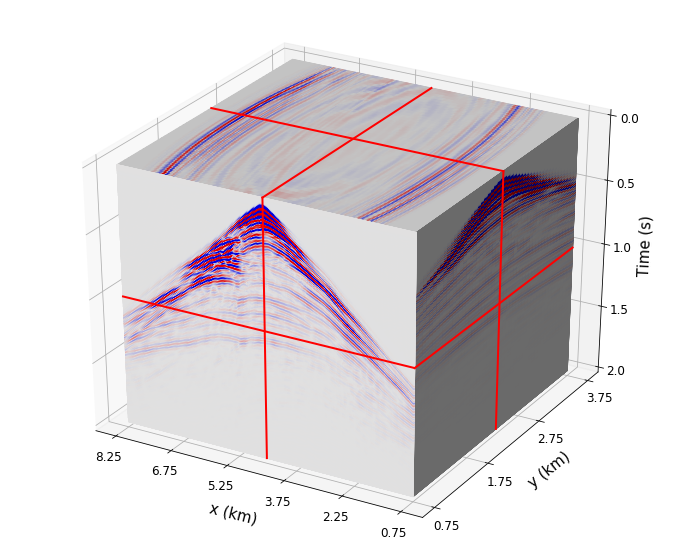

In [35]:
# display the 3-D data volume
rec = np.fromfile('./outputs/AGUpaper/hete_rec_hABC.dat',dtype=np.float32)
recdisp = np.reshape(rec,(nt,nxline*niline)).transpose()
recdisp = np.reshape(recdisp,(nxline,niline,nt))
clim = np.array([-0.001,0.001])*0.1
x = np.arange(50,551,2)*15
y = np.arange(50,251,4)*15
z = np.arange(nt)*dt
fig, _ = show3Ddata(recdisp, [x,y,z], [126,26,nt//2], clim=clim)

In [36]:
fig.savefig('./outputs/AGUpaper/hete_rec3D_hABC.png',dpi=600)

## (3) Display the waveform comparison between hABCs and naABCs

Text(0, 0.00063, 'x1e-4')

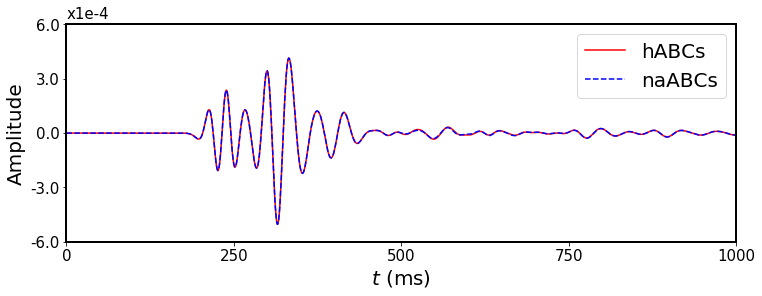

In [37]:
iNo = 35
xNo = 135
xtk = np.arange(0,2001,250)
ytk = np.array([-6,-3,0.0,3,6.0])*1e-4
ylim = [-0.0006,0.0006]
xlim = [0,1000]
# compare waveforms
R1 = rech[:,xNo,iNo]
R2 = recna[:,xNo,iNo]
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(R1,'r',linewidth=1.5,label='hABCs')
ax.plot(R2,'b--',linewidth=1.5,label='naABCs')

ax.set_xticks(xtk)
ax.set_xticklabels([f'{i}' for i in xtk],fontsize=15)
ax.set_yticks(ytk)
ax.set_yticklabels([f'{i*1e4:.1f}' for i in ytk],fontsize=15)

ax.set_xlabel('$t$ (ms)', fontsize=20)
ax.set_ylabel('Amplitude', fontsize=20)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.legend(fontsize=20)
if xlim is not None:
    ax.set_xlim(xlim[0],xlim[1])
if ylim is not None:
    ax.set_ylim(ylim[0],ylim[1])

ax.text(0,6.3e-4,'x1e-4',fontsize=15)

In [38]:
BB = ax.get_position()
BB.x0 = 0
BB.y0 = -0.3
BB.x1 = 13
BB.y1 = 4.5
fig.savefig('./outputs/AGUpaper/hete_rec1.png',dpi=600,bbox_inches=BB)

Text(1000, 4.3e-05, 'x1e-5')

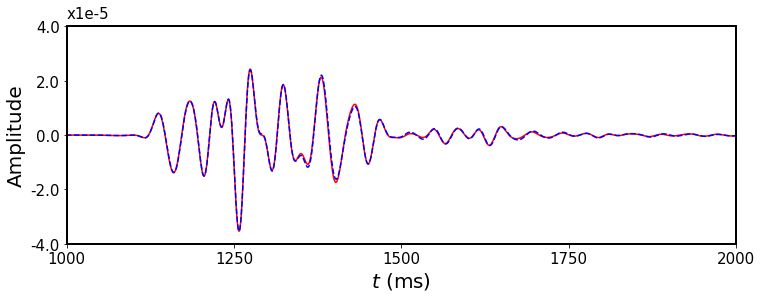

In [43]:
iNo = 5
xNo = 5
xtk = np.arange(1000,2001,250)
ytk = np.array([-4,-2,0.0,2,4])*1e-5
ylim = None#[-0.00001,0.00001]
xlim = [1000,2000]
# compare waveforms
R1 = rech[:,xNo,iNo]
R2 = recna[:,xNo,iNo]
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(R1,'r',linewidth=1.5,label='hABCs')
ax.plot(R2,'b--',linewidth=1.5,label='naABCs')

ax.set_xticks(xtk)
ax.set_xticklabels([f'{i}' for i in xtk],fontsize=15)
ax.set_yticks(ytk)
ax.set_yticklabels([f'{i*1e5}' for i in ytk],fontsize=15)

ax.set_xlabel('$t$ (ms)', fontsize=20)
ax.set_ylabel('Amplitude', fontsize=20)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
if xlim is not None:
    ax.set_xlim(xlim[0],xlim[1])
if ylim is not None:
    ax.set_ylim(ylim[0],ylim[1])

ax.text(1000,4.3e-5,'x1e-5',fontsize=15)

In [40]:
BB = ax.get_position()
BB.x0 = 0
BB.y0 = -0.3
BB.x1 = 13
BB.y1 = 4.5
fig.savefig('./outputs/AGUpaper/hete_rec2.png',dpi=600,bbox_inches=BB)

In [41]:
# runtime for preparing ABCs and low-rank decomposition
runtimepABCs = np.array([125.72,8.01])
runtimelrdec = np.array([38.33,25.35])
# recorded runtime without plotting snapshots
runtimeabc = np.array([469.31,995.56]) # corresponding to naABCs for vareps=0.04, 0.01 and hABCs for N=20
# when hABCs for N=10, runtime is 31.1s